<a href="https://colab.research.google.com/github/sohaibwaheedgithub/Machine-Learning-And-Deep-Learning-Projects/blob/main/Human_Activity_Recognition_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Project Summary
---------------
Human activity recognition System can Classify 6 different activities of a person
1. SITTING
2. STANDING
3. Walking
4. Walking Upstairs
5. Walking Downstairs
6. Laying

Inputs
------
Body acceleration, total acceleration and Gyroscope data recorded with smartphone Sensors

Outputs
-------
1. The next 3 timesteps values of given sensor data
2. Classification of Person's activity from above six activities

'''

In [ ]:
# Importing Libraries

import glob
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [ ]:
# Function to read datasets from mounted Google drive

def read_set(path, set_name, remaining_path):
    list_of_dfs = []
    pattern = path + set_name + remaining_path
    filepaths = glob.glob(pattern)
    for filepath in filepaths:
        df = pd.read_table(filepath, header = None, delim_whitespace = True)
        list_of_dfs.append(df)
    stack = len(list_of_dfs) > 1
    if stack:
        return np.dstack(list_of_dfs)
    else:
        return list_of_dfs[0].to_numpy() - 1

In [ ]:
# Reading dataset

dataset = read_set('/content/drive/MyDrive/', 'Inertial Signals train/', '*.txt')

In [ ]:
# Suffling datasets to avoid spurious hidden patterns and get the most out of Gradient Descent

np.random.seed(42)
shuffled_indices = np.random.permutation(dataset.shape[0])

dataset = dataset[shuffled_indices]

In [ ]:
# Splitting into train and validation sets and reading regression and classification targets from local directory
# For Regression, I will train model to predict 3 timesteps ahead at each timestep which can significantly increase 
# model's performance

In [ ]:
# Datasets and labels for Regression task

train_ratio = 0.70
valid_ratio = 0.85

train_size = int(dataset.shape[0] * train_ratio)
valid_size = int(dataset.shape[0] * valid_ratio)


X_train_A = dataset[:train_size, :125]
X_valid_A = dataset[train_size:valid_size, :125]
X_test_A = dataset[valid_size:, :125]

# Regression targets for train_set
regression_targets = np.empty((dataset.shape[0], 125, 27))
for i in range(1, 125+1):
    regression_targets[:, i-1] = dataset[:, i:i+3].reshape(dataset.shape[0], -1)

y_train_regression = regression_targets[:train_size]
y_valid_regression = regression_targets[train_size:valid_size]
y_test_regression = regression_targets[valid_size:]

In [ ]:
# Datasets and labels for Classification task

X_train_B = dataset[:train_size]
X_valid_B = dataset[train_size:valid_size]
X_test_B = dataset[valid_size:]

# Classification targets for train_set

classification_targets = read_set('/content/drive/MyDrive/', '', 'y_train.txt')
# Shuffling train classificaton targets
classification_targets = classification_targets[shuffled_indices]


y_train_classification = classification_targets[:train_size]
y_valid_classification = classification_targets[train_size:valid_size]
y_test_classification = classification_targets[valid_size:]

In [ ]:
# Building RNN Model Architecture using keras Functional API

features = dataset.shape[2]
n_classes = np.unique(classification_targets[:, 0]).shape[0]


# For Regression task
Input_A = keras.layers.Input(shape = [None, features])
hidden_1A = keras.layers.GRU(100, return_sequences = True)(Input_A)
hidden_2A = keras.layers.GRU(50, return_sequences = True)(hidden_1A)
hidden_3A = keras.layers.GRU(20, return_sequences = True)(hidden_2A)
regression_output = keras.layers.TimeDistributed(keras.layers.Dense(27), 
                                                 name = 'Regression_Output')(hidden_3A)

# For Classification task
Input_B = keras.layers.Input(shape = [None, features])
hidden_1B = keras.layers.GRU(300, return_sequences = True)(Input_B)
hidden_2B = keras.layers.GRU(100, return_sequences = True)(hidden_1B)
hidden_3B = keras.layers.GRU(50, return_sequences = True)(hidden_2B)
hidden_4B = keras.layers.GRU(20)(hidden_3B)
classification_output = keras.layers.Dense(n_classes, activation = 'softmax', 
                                           name = 'Classification_Output')(hidden_4B)

RNN_model = keras.Model(inputs = [Input_A, Input_B], outputs = [regression_output, classification_output])

In [ ]:
# Defining custom metric for evaluation because I only need to see the loss for all timesteps during training
# But during evaluation the predictions of only last timestep matters

def Custom_mse(y_true, y_pred):
    return keras.metrics.mean_squared_error(y_true[:, -1], y_pred[:, -1])

In [ ]:
# Compilation of RNN_model

RNN_model.compile(loss = {'Regression_Output': 'mse',
                          'Classification_Output': 'sparse_categorical_crossentropy'
                         },
                  optimizer = keras.optimizers.Adam(),
                  metrics = {'Regression_Output': Custom_mse,
                             'Classification_Output': 'accuracy'
                             }
                 )

# Creating Callback to implement Early Stopping

earlystopping_cb = keras.callbacks.EarlyStopping(patience = 15,
                                                 restore_best_weights = True
                                                )

# Training Model

history = RNN_model.fit((X_train_A, X_train_B), (y_train_regression, y_train_classification),
                        epochs = 100,
                        validation_data = ((X_valid_A, X_valid_B), (y_valid_regression, y_valid_classification)),
                        callbacks = [earlystopping_cb]

                        )

Epoch 1/100
161/161 [==============================] - 17s 55ms/step - loss: 1.0441 - Regression_Output_loss: 0.0515 - Classification_Output_loss: 0.9926 - Regression_Output_Custom_mse: 0.0508 - Classification_Output_accuracy: 0.5985 - val_loss: 0.5522 - val_Regression_Output_loss: 0.0296 - val_Classification_Output_loss: 0.5226 - val_Regression_Output_Custom_mse: 0.0281 - val_Classification_Output_accuracy: 0.8051
Epoch 2/100
161/161 [==============================] - 6s 40ms/step - loss: 0.4396 - Regression_Output_loss: 0.0225 - Classification_Output_loss: 0.4171 - Regression_Output_Custom_mse: 0.0219 - Classification_Output_accuracy: 0.8548 - val_loss: 0.3303 - val_Regression_Output_loss: 0.0203 - val_Classification_Output_loss: 0.3101 - val_Regression_Output_Custom_mse: 0.0197 - val_Classification_Output_accuracy: 0.8858
Epoch 3/100
161/161 [==============================] - 6s 40ms/step - loss: 0.2043 - Regression_Output_loss: 0.0180 - Classification_Output_loss: 0.1863 - Regressi

In [ ]:
# Evaluating on the test set to see how well the model generalize

RNN_model.evaluate((X_test_A, X_test_B), (y_test_regression, y_test_classification))

35/35 [==============================] - 12s 206ms/step - loss: 0.0293 - Regression_Output_loss: 0.0087 - Classification_Output_loss: 0.0205 - Regression_Output_Custom_mse: 0.0079 - Classification_Output_accuracy: 0.9927


[0.029250040650367737,
 0.008715984411537647,
 0.020534055307507515,
 0.007878661155700684,
 0.9927470684051514]

In [ ]:
# The model is generalizing with 99.27% Accuracy and 0.007 mean squared error
# Let us display some regression predictions

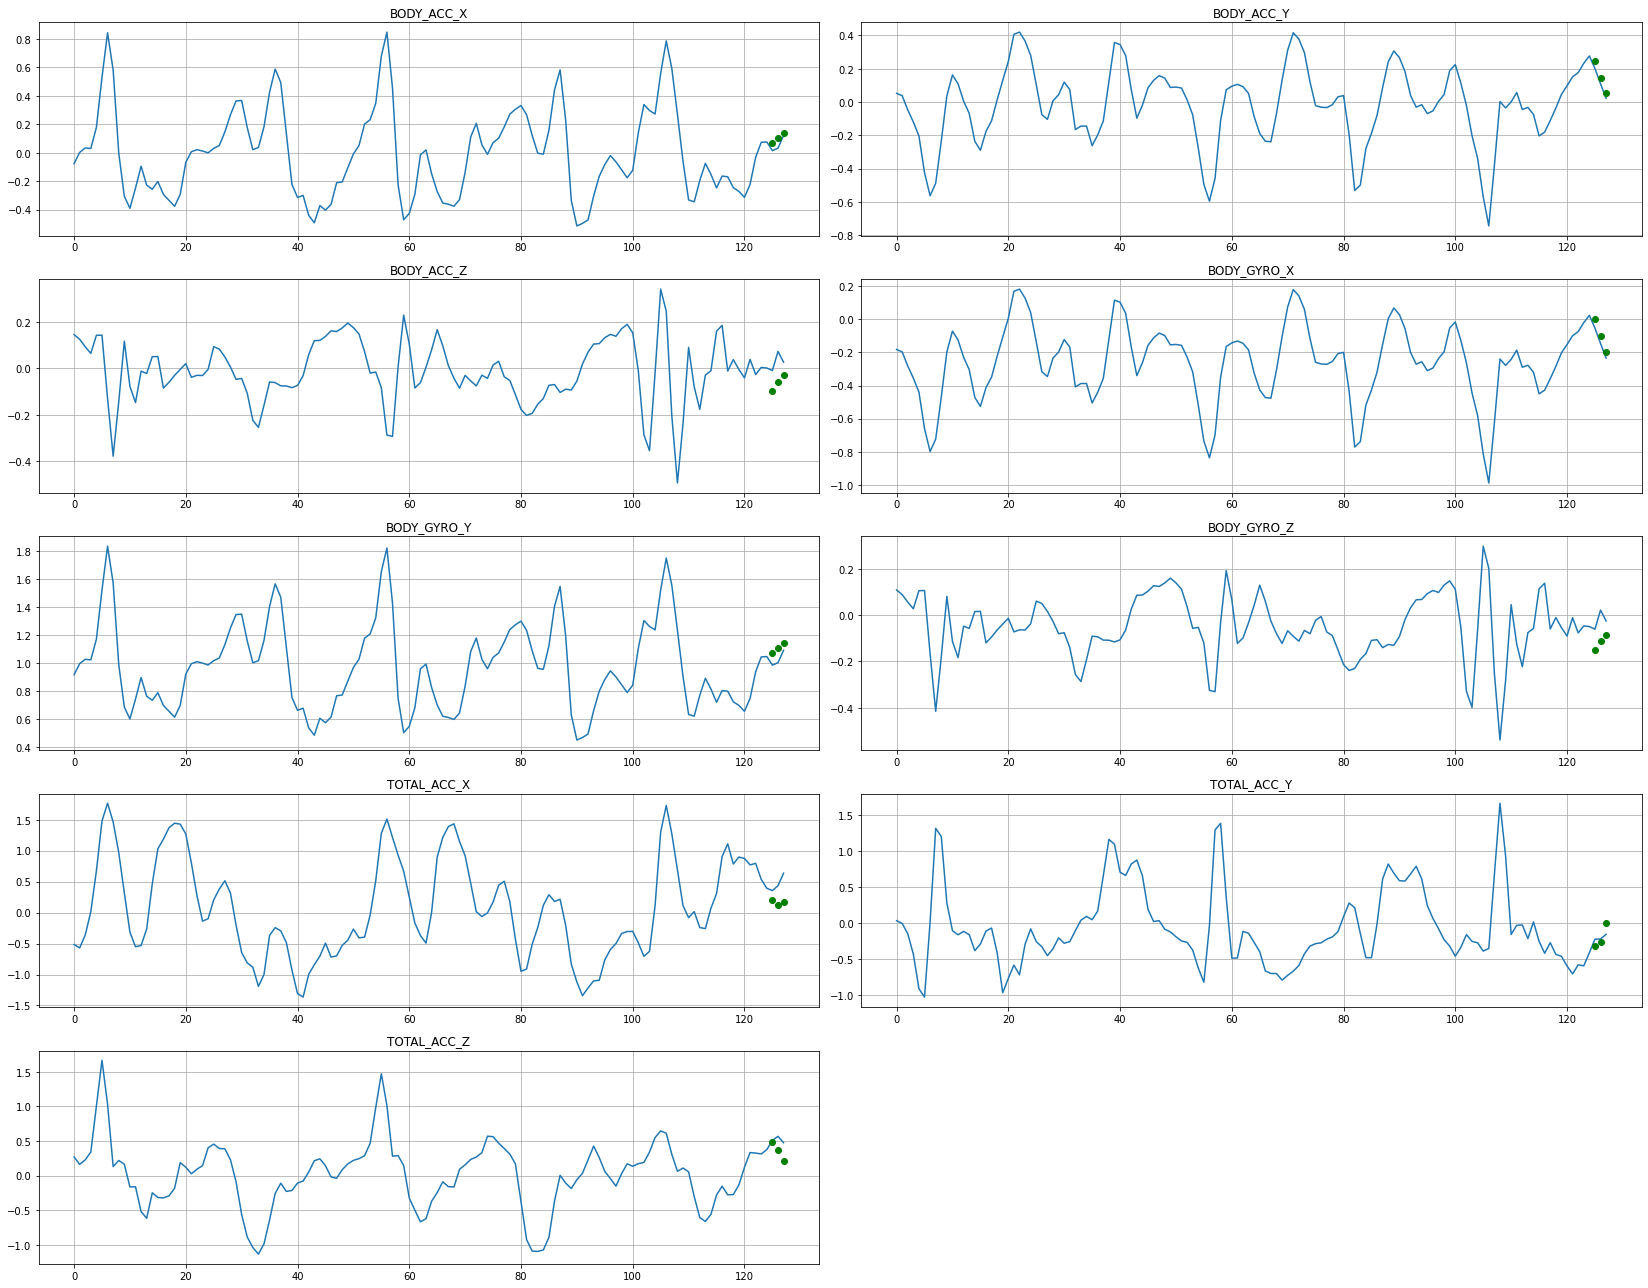

In [ ]:
feature_names = ['BODY_' + i + '_' + j for i in ['ACC', 'GYRO'] for j in 'XYZ'] 
feature_names += ['TOTAL_ACC_' + i for i in 'XYZ']

np.random.seed(100)
random_indices = np.random.permutation(X_test_A.shape[0])[:10]

instance = X_test_B[random_indices[0]].reshape(128, 9)

reg_output, cls_output = RNN_model.predict((X_test_A[random_indices], X_test_B[random_indices]))

output = reg_output[0, -1:, :].reshape(3, 9)
timesteps_to_predict = list(range(125, 128))

fig = plt.figure(figsize = (23, 18))
for feature in range(features):
  fig.add_subplot(5, 2, feature+1)
  plt.plot(instance[:, feature])
  plt.title(feature_names[feature])
  plt.plot(timesteps_to_predict, output[:, feature], 'og')
  plt.grid(True)
plt.tight_layout()

In [ ]:
# As we can see the model has almost got adopted to the trend
# and forecasting the next 3 values for most of the features with good precision
# Let us display some classification predictions

In [ ]:
Labels = ['WALKING', 'WALKING UPSTAIRS', 'WALKING DOWNSTAIRS',
          'SITTING', 'STANDING', 'LAYING']

In [ ]:
# Function to display predictions

def display_pred(y_true, y_pred):
    for x, y in zip(y_true, y_pred):
        print('Original Label: {} ----- Predicted Label: {}'.format(Labels[x], Labels[y]))
        print('\n')

In [ ]:
# Displaying Predictions

y_true = y_test_classification[random_indices].reshape(-1)
y_pred = np.argmax(cls_output, axis = 1)
display_pred(y_true, y_pred)

Original Label: WALKING ----- Predicted Label: WALKING


Original Label: STANDING ----- Predicted Label: STANDING


Original Label: LAYING ----- Predicted Label: LAYING


Original Label: WALKING DOWNSTAIRS ----- Predicted Label: WALKING DOWNSTAIRS


Original Label: STANDING ----- Predicted Label: STANDING


Original Label: LAYING ----- Predicted Label: LAYING


Original Label: STANDING ----- Predicted Label: SITTING


Original Label: WALKING ----- Predicted Label: WALKING


Original Label: WALKING UPSTAIRS ----- Predicted Label: WALKING UPSTAIRS


Original Label: WALKING ----- Predicted Label: WALKING




In [ ]:
# It has predicted 9 out of 10 labels correctly